# Training Data




## This notebook assumes you have the DC2 data downloaded  

You will have to change directorty paths

In [1]:
# In case you need to point to pre-existing scarlet install
import sys
#sys.path.insert(0, '/home/yse2/deepdisc/src')
#sys.path.insert(0, '/home/yse2/detectron2')
import deepdisc
import detectron2
print(deepdisc.__file__)
print(detectron2.__file__)

/home/g4merz/deepdisc/src/deepdisc/__init__.py
/home/g4merz/detectron2/detectron2/__init__.py


In [2]:
# Standard imports
import sys, os
import numpy as np
import time
import glob

import scarlet
import sep
import cv2


import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D

# Astrodet imports
import deepdisc.preprocessing.detection as detection
import deepdisc.preprocessing.process as process

from deepdisc.astrodet.hsc import get_tract_patch_from_coord, get_hsc_data

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt

# use a better colormap and don't interpolate the pixels
#matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')
from skimage.util.shape import view_as_blocks
from matplotlib import colors

import pandas as pd
import math
from astropy.table import Table

In [3]:
from deepdisc.preprocessing.get_data import get_cutout
filters = ['u','g','r','i','z','y']
#dirpath = '/home/g4merz/DC2/coadd-t3828-t3829/deepCoadd-results/'
dirpath = '/home/shared/hsc/DC2/raw_data/dr6/'
nb=16 #The number of cutouts per side of an image.  4k CCDs are too large to train with, so we reduce the size
sp=22 #The "subpatch", i.e. which of the nb x nb cutouts to use 

In [4]:
with fits.open(os.path.join(dirpath,'3078_3,4_images.fits')) as hdul:
    h = hdul[1].header

### Using an input catalog

The cells below assume you have an input catalog `all_tracts_cat.csv` corresponding to the tracts and patches you've downloaded.  We can run the code without one, but it is necessary for truth-matching any quantities

In [5]:
import importlib
importlib.reload(deepdisc.preprocessing.get_data)
import deepdisc.preprocessing.get_data 
from deepdisc.preprocessing.get_data import get_cutout
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma

In [ ]:
dall=pd.read_csv('/home/shared/hsc/DC2/raw_data/all_tracts_truth_cat.csv')
#dall=pd.read_csv('/home/g4merz/DC2/nersc_data/data/tracts_data/all_tracts_cat.csv')

ra_all = dall['ra'][:].values
dec_all = dall['dec'][:].values
allcatalog = SkyCoord(ra=ra_all*u.degree, dec=dec_all*u.degree)

In [6]:
# dpatch=pd.read_csv('/home/shared/hsc/DC2/raw_data/3828_1,2_truthcat.csv')
dpatch=pd.read_csv('/home/shared/hsc/DC2/raw_data/3828_1,2_truthcat.csv')
#dpatch = pd.read_csv('/home/shared/hsc/roman_lsst/3828_all_gal_star_cat.csv')

ra_patch = dpatch['ra'][:].values
dec_patch = dpatch['dec'][:].values
patchcatalog = SkyCoord(ra=ra_patch*u.degree, dec=dec_patch*u.degree)

In [7]:
dpatch.keys()

Index(['Unnamed: 0', 'morphology/totalEllipticity', 'redshift',
       'SDSS_filters/diskLuminositiesStellar:SDSS_i:observed',
       'morphology/spheroidEllipticity', 'size_minor_bulge_true',
       'size_disk_true', 'shear_1', 'mag_i',
       'LSST_filters/diskLuminositiesStellar:LSST_u:observed',
       'ellipticity_1_disk_true', 'convergence', 'morphology/positionAngle',
       'dec', 'ellipticity_2_bulge_true',
       'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed',
       'mag_true_u', 'ra', 'R_v', 'ellipticity_2_true',
       'SDSS_filters/diskLuminositiesStellar:SDSS_z:observed',
       'size_minor_true', 'A_v', 'ellipticity_1_true',
       'SDSS_filters/diskLuminositiesStellar:SDSS_r:observed', 'galaxy_id',
       'LSST_filters/diskLuminositiesStellar:LSST_y:observed',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_i:observed',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_g:observed',

In [8]:
#print("# of Stars: ", len(dpatch[dpatch['truth_type'] == 2]), "\n# of Galaxies: ", len(dpatch[dpatch['truth_type'] == 1]))

In [9]:
#fitscat = Table.read('/home/shared/hsc/DC2/raw_data/btk_3828_1,2_truthcat.fits', format='fits')
#dpatch_btk = fitscat.to_pandas()

#ra_patch_btk = dpatch_btk['ra'][:].values
#dec_patch_btk = dpatch_btk['dec'][:].values
#patchcatalog_btk = SkyCoord(ra=ra_patch_btk*u.degree, dec=dec_patch_btk*u.degree)

In [10]:
def get_cutout_cat(dirpath,dcat,skycoords, id_col, tract,patch,sp,nblocks=4,filters=['u','g','r','i','z','y']):
    '''
        WARNING!!!!!
        It is not efficient to have the full catalog (defined here as dall) as input to a function when doing multiprocesing.  
        Keep it in the top level process
    '''
    # the below should work properly
    cutout,datsm, psf = get_cutout(dirpath,tract=tract,patch=patch,sp=sp,nblocks=nblocks,filters=filters,plot=False, get_psf=True)
    xs,ys = cutout.wcs.world_to_pixel(skycoords)

    inds = np.where((xs>=0) & (xs<cutout.shape[1]-1) & (ys>=0) & (ys<cutout.shape[0]-1))[0]
    
 
    dcut = dcat.iloc[inds]

    dcut['new_x'] = xs[inds]
    dcut['new_y'] = ys[inds]
    
#     dcut = dcut[dcut['mag_i']<25.3] # REMOVE THIS CUT

    
#     column_to_move = dcut.pop(id_col)

#     # insert column with insert(location, column_name, column_value)
#     dcut.insert(0, id_col, column_to_move)
#     dcut.sort_values(by=id_col)
    
    return datsm, dcut#, psf

In [11]:
# doable with combined catalog just pass in both galaxy_id and id to move to the beginning of df
# datsm,dcut,psf = get_cutout_cat(dirpath, dpatch, patchcatalog, 'galaxy_id', '3828','1,2',21,nblocks=8)
datsm, dcut = get_cutout_cat(dirpath, dpatch, patchcatalog, 'galaxy_id', '3828','1,2', sp, nblocks=8)

#datsm2,dcut2,psf2 = get_cutout_cat(dirpath, dpatch_btk, patchcatalog_btk, 'galaxy_id', '3828','1,2',29,nblocks=16)

/tmp/ipykernel_1699522/3931048781.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_1699522/3931048781.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_y'] = ys[inds]


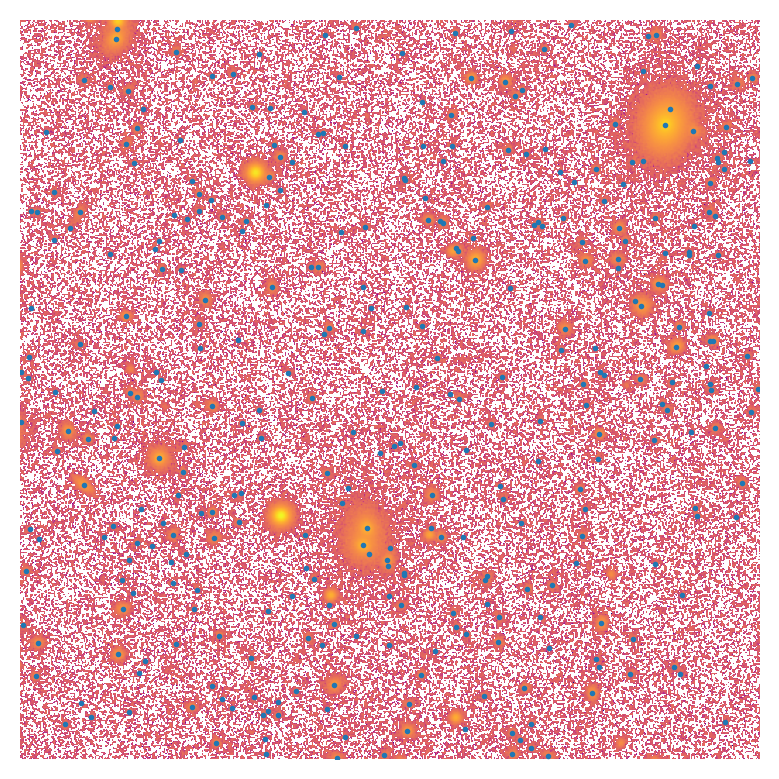

In [12]:
# plotting the i filter and corresponding data
plt.imshow(datsm[3],norm=colors.LogNorm(), cmap='plasma')
plt.axis('off')
plt.scatter(dcut.new_x.values,dcut.new_y.values,s=1)

In [13]:
L0 = 3.0128e28

def e1e2_to_ephi(e1,e2):
    
    pa = np.arctan(e2/e1)
    
    return pa

def dcut_reformat(cat, only_bttri=False):
    
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        cat[f'{band}_ab'] = cat[f'mag_true_{band}']
    
    # only bulge to total ratio i-band from the cosmoDC2 GCR Catalog
    if only_bttri:
        total_flux = L0 * 10**(-0.4*cat[f'mag_true_i'])
        bulge_to_total_ratio = cat[f'bulge_to_total_ratio_i']

        cat[f'fluxnorm_bulge_i'] = total_flux * bulge_to_total_ratio
        cat[f'fluxnorm_disk_i'] = total_flux * (1-bulge_to_total_ratio)
        cat[f'fluxnorm_agn_i'] = np.zeros(total_flux.shape)
    else:
        for band in ['u', 'g', 'r', 'i', 'z', 'y']:
            total_flux = L0 * 10**(-0.4*cat[f'mag_true_{band}'])
            bulge_to_total_ratio = cat[f'bulge_to_total_ratio_{band}']

            cat[f'fluxnorm_bulge_{band}'] = total_flux * bulge_to_total_ratio
            cat[f'fluxnorm_disk_{band}'] = total_flux * (1-bulge_to_total_ratio)
            cat[f'fluxnorm_agn_{band}'] = np.zeros(total_flux.shape)

    cat['a_b'] = cat['size_bulge_true']
    cat['b_b'] = cat['size_minor_bulge_true']

    cat['a_d'] = cat['size_disk_true']
    cat['b_d'] = cat['size_minor_disk_true']

    cat['pa_bulge'] = e1e2_to_ephi(cat['ellipticity_1_bulge_true'],cat['ellipticity_2_bulge_true']) * 180.0/np.pi

    cat['pa_disk'] = e1e2_to_ephi(cat['ellipticity_1_disk_true'],cat['ellipticity_2_disk_true']) * 180.0/np.pi
    
    cat['pa_tot'] = e1e2_to_ephi(cat['ellipticity_1_true'],cat['ellipticity_2_true']) * 180.0/np.pi

    cat['g1'] = cat['shear_1']
    cat['g2'] = cat['shear_2']
    
    return cat


## Create annotations for each detected object based on the ellipticity and size(hlr)

In [14]:
from galcheat.utilities import mag2counts, mean_sky_level
from btk.survey import Filter, Survey, make_wcs
import galsim
import btk

seed = 8312
rng = np.random.RandomState(seed)
grng = galsim.BaseDeviate(rng.randint(0, 2**30))

def get_star_gsparams(mag, flux, noise):
    """
    Get appropriate gsparams given flux and noise

    Parameters
    ----------
    mag: float
        mag of star
    flux: float
        flux of star
    noise: float
        noise of image

    Returns
    --------
    GSParams, isbright where isbright is true for stars with mag less than 18
    """
    do_thresh = do_acc = False
    if mag < 18:
        do_thresh = True
    if mag < 15:
        do_acc = True

    if do_thresh or do_acc:
        isbright = True

        kw = {}
        if do_thresh:

            # this is designed to quantize the folding_threshold values,
            # so that there are fewer objects in the GalSim C++ cache.
            # With continuous values of folding_threshold, there would be
            # a moderately largish overhead for each object.

            folding_threshold = noise/flux
            folding_threshold = np.exp(
                np.floor(np.log(folding_threshold))
            )
            kw['folding_threshold'] = min(folding_threshold, 0.005)

        if do_acc:
            kw['kvalue_accuracy'] = 1.0e-8
            kw['maxk_threshold'] = 1.0e-5

        gsparams = galsim.GSParams(**kw)
    else:
        gsparams = None
        isbright = False

    return gsparams, isbright


def make_star(entry, survey, filt):
    """
    Parameters
    ----------
    survey: WLDeblendSurvey or BasicSurvey
        The survey object
    band: string
        Band string, e.g. 'r'
    i: int
        Index of object
    noise: float
        The noise level, needed for setting gsparams

    Returns
    -------
    galsim.GSObject
    """    
    
    #https://pipelines.lsst.io/v/DM-22499/cpp-api/file/_photo_calib_8h.html
    mag = -2.5*np.log10(entry[f'flux_{filt.name}']*1e-9/(1e23*10**(48.6/-2.5)))
    flux = mag2counts(mag,survey,filt).to_value("electron")
    #mag = entry[f'mag_true_{filt.name}']
    #flux = entry[f'flux_{filt.name}']
    noise = mean_sky_level(survey, filt).to_value('electron') # gain = 1
    gsparams, isbright = get_star_gsparams(mag, flux, noise)
    
    star = galsim.Gaussian(
        fwhm=1.0e-4,
        flux=flux,
        gsparams=gsparams,
    )
    return star, gsparams, isbright

def make_galaxy(entry, survey, filt, no_disk= False, no_bulge = False, no_agn = True):
    components = []
    total_flux = mag2counts(entry[filt.name + "_ab"], survey, filt).to_value("electron")
    # Calculate the flux of each component in detected electrons.
    total_fluxnorm = entry["fluxnorm_disk_"+filt.name] + entry["fluxnorm_bulge_"+filt.name] + entry["fluxnorm_agn_"+filt.name]
    disk_flux = 0.0 if no_disk else entry["fluxnorm_disk_"+filt.name] / total_fluxnorm * total_flux
    bulge_flux = 0.0 if no_bulge else entry["fluxnorm_bulge_"+filt.name] / total_fluxnorm * total_flux
    agn_flux = 0.0 if no_agn else entry["fluxnorm_agn_"+filt.name] / total_fluxnorm * total_flux

    if disk_flux + bulge_flux + agn_flux == 0:
        raise SourceNotVisible

    if disk_flux > 0:
        a_d, b_d = entry["a_d"], entry["b_d"]
        disk_hlr_arcsecs=entry['size_disk_true']
        
        
        disk_q = entry['size_minor_disk_true']/entry['size_disk_true']
        pa = np.pi*entry['position_angle_true_dc2']/180
        
        epsilon_disk = (1 - disk_q) / (1 + disk_q)
        
        e1_disk = epsilon_disk * np.cos(2 * pa)
        e2_disk = epsilon_disk * np.sin(2 * pa)

        disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
            e1=-e1_disk, e2=e2_disk
        )
        
        components.append(disk)
        
        
    if bulge_flux > 0:
        a_b, b_b = entry["a_b"], entry["b_b"]
        bulge_hlr_arcsecs = np.sqrt(a_b * b_b)

        bulge_q = entry['size_minor_bulge_true']/entry['size_bulge_true']

        pa = np.pi*entry['position_angle_true_dc2']/180

        
        epsilon_bulge = (1 - bulge_q) / (1 + bulge_q)
        
        e1_bulge = epsilon_bulge * np.cos(2 * pa)
        e2_bulge = epsilon_bulge * np.sin(2 * pa)
        
        bulge = galsim.DeVaucouleurs(flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs).shear(
           e1=-e1_bulge, e2=e2_bulge
        )
        components.append(bulge)

    if agn_flux > 0:
        agn = galsim.Gaussian(flux=agn_flux, sigma=1e-8)
        components.append(agn)

    profile = galsim.Add(components)
    return profile

def make_seg(entry, survey, filt, lvl,nx=128,ny=128):
    psf = survey.get_filter(filt).psf
    sky_level = mean_sky_level(survey, filt).to_value('electron') # gain = 1
    obj_type = entry['truth_type'] # 1 for galaxies, 2 for stars
    im = None
    if obj_type == 1:
        gal = make_galaxy(entry, survey, survey.get_filter(filt))
        gal = gal.shear(g1=entry["g1"], g2=entry["g2"])
        conv_gal = galsim.Convolve(gal, psf)
        im = conv_gal.drawImage(
            nx=nx,
            ny=nx,
            scale=survey.pixel_scale.to_value("arcsec")
        )
    else:
        star, gsparams, isbright = make_star(entry, survey, survey.get_filter(filt))
        max_n_photons = 10_000_000
        # 0 means use the flux for n_photons 
        mag = -2.5*np.log10(entry[f'flux_{filt}']*1e-9/(1e23*10**(48.6/-2.5)))
        flux = mag2counts(mag,survey,filt).to_value("electron")
        n_photons = 0 if flux < max_n_photons else max_n_photons
        #n_photons = 0 if entry[f'flux_{filt}'] < max_n_photons else max_n_photons
        conv_star = galsim.Convolve(star, psf)
        im = conv_star.drawImage(
            nx=nx,
            ny=nx,
            scale=survey.pixel_scale.to_value("arcsec"),
            method="phot",
            n_photons=n_photons,
            poisson_flux=True,
            maxN=1_000_000,  # shoot in batches this size
            rng=grng
        )
        
    imd = np.expand_dims(np.expand_dims(im.array,0),0)
    # thresh for mask set relative to the bg noise level which is what sigma_noise is
    # so lower the thresh for the star to include more of its light
    # so lower sigma_noise, bigger masks and higher lvl, smaller masks bc it'll only capture very brightest central part of star
    if obj_type == 2: # if star, 
        segs = btk.metrics.utils.get_segmentation(imd, sky_level, sigma_noise=lvl)
    else:
        segs = btk.metrics.utils.get_segmentation(imd, sky_level, sigma_noise=lvl)        
    return segs[0][0]




def make_im(entry, survey, filt, lvl,nx=128,ny=128):
    psf = survey.get_filter(filt).psf
    sky_level = mean_sky_level(survey, filt).to_value('electron') # gain = 1
    obj_type = entry['truth_type'] # 1 for galaxies, 2 for stars
    im = None
    if obj_type == 1:
        gal = make_galaxy(entry, survey, survey.get_filter(filt))
        gal = gal.shear(g1=entry["g1"], g2=entry["g2"])
        conv_gal = galsim.Convolve(gal, psf)
        im = conv_gal.drawImage(
            nx=nx,
            ny=nx,
            scale=survey.pixel_scale.to_value("arcsec")
        )
    else:
        star, gsparams, isbright = make_star(entry, survey, survey.get_filter(filt))
        max_n_photons = 10_000_000
        # 0 means use the flux for n_photons 
        mag = -2.5*np.log10(entry[f'flux_{filt}']*1e-9/(1e23*10**(48.6/-2.5)))
        flux = mag2counts(mag,survey,filt).to_value("electron")
        n_photons = 0 if flux < max_n_photons else max_n_photons
        #n_photons = 0 if entry[f'flux_{filt}'] < max_n_photons else max_n_photons
        conv_star = galsim.Convolve(star, psf)
        im = conv_star.drawImage(
            nx=nx,
            ny=nx,
            scale=survey.pixel_scale.to_value("arcsec"),
            method="phot",
            n_photons=n_photons,
            poisson_flux=True,
            maxN=1_000_000,  # shoot in batches this size
            rng=grng
        )
        
    return im
        
    


def get_bbox(mask):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin-4, rmax+4, cmin-4, cmax+4

In [32]:
from astropy.stats import gaussian_fwhm_to_sigma

#the psf variations are small between bands, so just using i-band is ok
fwhm = survey.get_filter(filt).psf.calculateFWHM()
sig = gaussian_fwhm_to_sigma*fwhm/.2
SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(2*sig),int(2*sig)))


def create_metadata(dat, cat, survey, filt, lvl=3):

    """ Code to format the metadatain to a dict.  It takes the i-band and makes a footprint+bounding boxes
    from thresholding to sn*sky_level
    
    Parameters
    
    blend_batch: BTK blend batch
        BTK batch of blends
    sky_level: float
        The background sky level in the i-band
    sn: int
        The signal-to-noise ratio for thresholding
    idx:
        The index of the blend in the blend_batch
        
    Returns
        ddict: dict
            The dictionary of metadata for the idx'th blend in the batch 
    
    """
    

    ddict = {}

    ddict[f"file_name"] = 'none'
    ddict["image_id"] = 0
    ddict["height"] = dat.shape[1]
    ddict["width"] = dat.shape[2]
    
    
    t = Table.from_pandas(cat)
    
    n = len(cat)
    objs = []
    
    bad_ann_inds = []
    for j in range(n):

        obj = t[j]
        #a = math.ceil(obj['size_true']/0.2)*2
        #b = math.ceil(obj['size_minor_true']/0.2)*2
        x = obj['new_x']
        y = obj['new_y']
        #mask = make_seg(obj,survey,filt, lvl)
        
        segs = []
        for filt in ['u','g','r','i','z','y']:
            im  = make_im(obj, survey, filt, lvl=lvl, nx=128,ny=128)
    
            imd = np.expand_dims(np.expand_dims(im.array,0),0)
            sky_level = mean_sky_level(survey, filt).to_value('electron') # gain = 1
            segs.append(btk.metrics.utils.get_segmentation(imd, sky_level, sigma_noise=lvl))

        mask = np.clip(np.sum(segs,axis=0), a_min=0, a_max=1)[0][0]
        
        #dilate by the psf size
        mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, SE)   

        #mask=cv2.ellipse(frame, (frame.shape[0]//2,frame.shape[1]//2), (a,b), pa, 0 , 360, (255,0,0), -1)
        #frame = np.zeros((dat.shape[1],dat.shape[2]))
        #mask=cv2.ellipse(frame, (0,0), (a,b), pa, 0 , 360, (255,0,0), -1)
        #print(obj["truth_type"], ": " ,mask, "\n")
        if np.sum(mask)==0:
            print('No mask', j)
            bad_ann_inds.append(j)
            continue
        
        bbox = get_bbox(mask)
        x0 = bbox[2]
        x1 = bbox[3]
        y0 = bbox[0]
        y1 = bbox[1]
        
        w = x1-x0
        h = y1-y0
        
        bbox = [x-w/2, y-h/2, w, h]     

        redshift = obj['redshift']

        contours, hierarchy = cv2.findContours(
                    (mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
                )


        segmentation = []
        for contour in contours:
            # contour = [x1, y1, ..., xn, yn]
            contour = contour.flatten()
            if len(contour) > 4:
                contour[::2] += (int(np.rint(x))-x0-w//2)
                contour[1::2] += (int(np.rint(y))-y0-h//2)
                #contour[::2] += (int(y)-y0-h//2)
                #contour[1::2] += (int(x)-x0-w//2)
                
                segmentation.append(contour.tolist())
        # No valid countors
        if len(segmentation) == 0:
            print('No valid contours', j)
            continue

        obj = {
            "bbox": bbox,
            "area": w*h,
            #"bbox_mode": BoxMode.XYWH_ABS,
            "bbox_mode": 1,
            "segmentation": segmentation,
            "category_id": 1 if obj['truth_type'] == 2 else 0,
            "redshift": redshift
        }
        objs.append(obj)

    ddict['annotations'] = objs

    return ddict, bad_ann_inds

In [16]:
#datsm, dcut = get_cutout_cat(dirpath, dpatch, patchcatalog, 'galaxy_id', '3828','1,2', sp, nblocks=8)
#dcutr = dcut_reformat(dcut, only_bttri=False)
#dcutr['truth_type'] = 1

In [ ]:
ab_magnitude += self.extinction*(self.airmass -zeropoint_airmass)
return self.exposure_time*self.zero_point*10**(-0.4*(ab_magnitude-24))

/tmp/ipykernel_1699522/3931048781.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_1699522/3931048781.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_y'] = ys[inds]
/tmp/ipykernel_1699522/3282477808.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

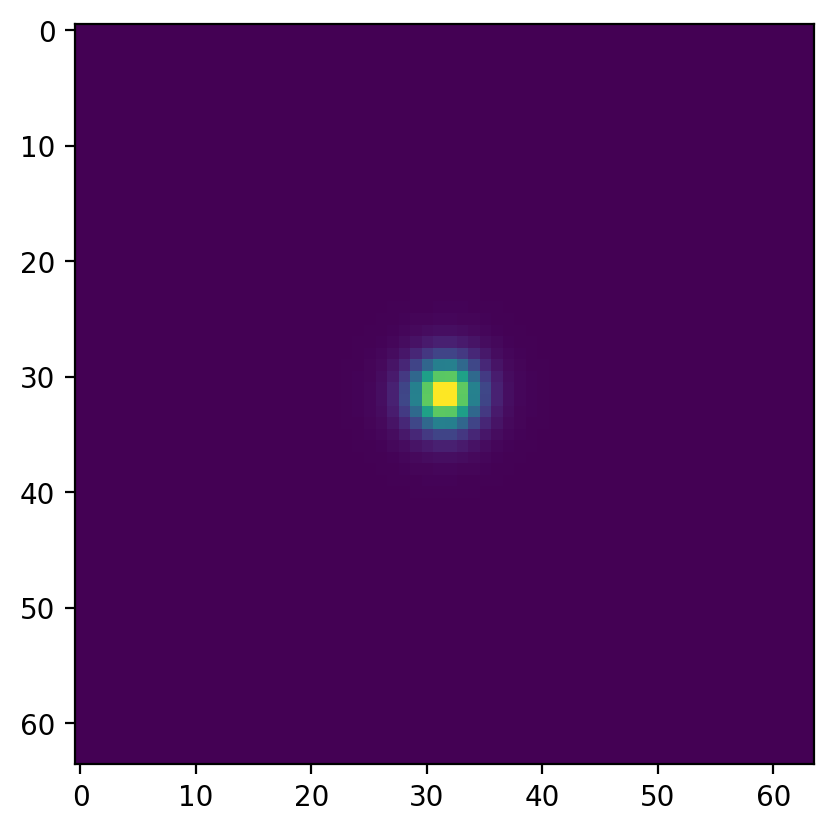

In [17]:
datsm, dcut = get_cutout_cat(dirpath, dpatch, patchcatalog, 'galaxy_id', '3828','1,2', sp, nblocks=8)
dcutr = dcut_reformat(dcut, only_bttri=False)
dcutr['truth_type'] = 1
dt = Table.from_pandas(dcutr)
survey = btk.survey.get_surveys("LSST")
filt = 'i'
nx=64
ny=64
entry = dt[261]
gal = make_galaxy(entry, survey, survey.get_filter(filt))
#ang = entry['position_angle_true'] -entry['morphology/positionAngle']

e1 = entry['morphology/totalEllipticity'] * np.cos(2*entry['position_angle_true'])
e2 = entry['morphology/totalEllipticity'] * np.sin(2*entry['position_angle_true'])
ang = e1e2_to_ephi(e1,e2)*180/np.pi

gal = gal.rotate(galsim.Angle(ang, unit=galsim.degrees))
gal = gal.shear(e1=entry["g1"], e2=entry["g2"])
gal_conv = galsim.Convolve(gal, psf)
scale = survey.pixel_scale.to_value("arcsec")
gal_conv2 = galsim.Convolve(gal_conv, psf)
#im = gal_conv.drawImage(nx=64,ny=64,scale=scale)
#impre = gal.drawImage(nx=64,ny=64,scale=survey.pixel_scale.to_value("arcsec"))

image = galsim.Image(nx,ny, scale=survey.pixel_scale.to_value("arcsec"))
im = gal_conv.drawImage(image,scale=scale,method='no_pixel')
#impre = gal.drawImage(image,scale=survey.pixel_scale.to_value("arcsec"))


#fig,ax = plt.subplots(1,2,figsize=(10,5))
#ax[0].imshow(im.array)
#ax[1].imshow(impre.array)
plt.imshow(im.array)

In [19]:
segs = []
for filt in ['u','g','r','i','z','y']:
    im  = make_im(entry, survey, filt, lvl=2, nx=64,ny=64)
    imd = np.expand_dims(np.expand_dims(im.array,0),0)
    sky_level = mean_sky_level(survey, filt).to_value('electron')
    segs.append(btk.metrics.utils.get_segmentation(imd, sky_level, sigma_noise=2))
    #print(imd.max(), np.sqrt(sky_level))
mask = np.clip(np.sum(segs,axis=0), a_min=0, a_max=1)[0][0]



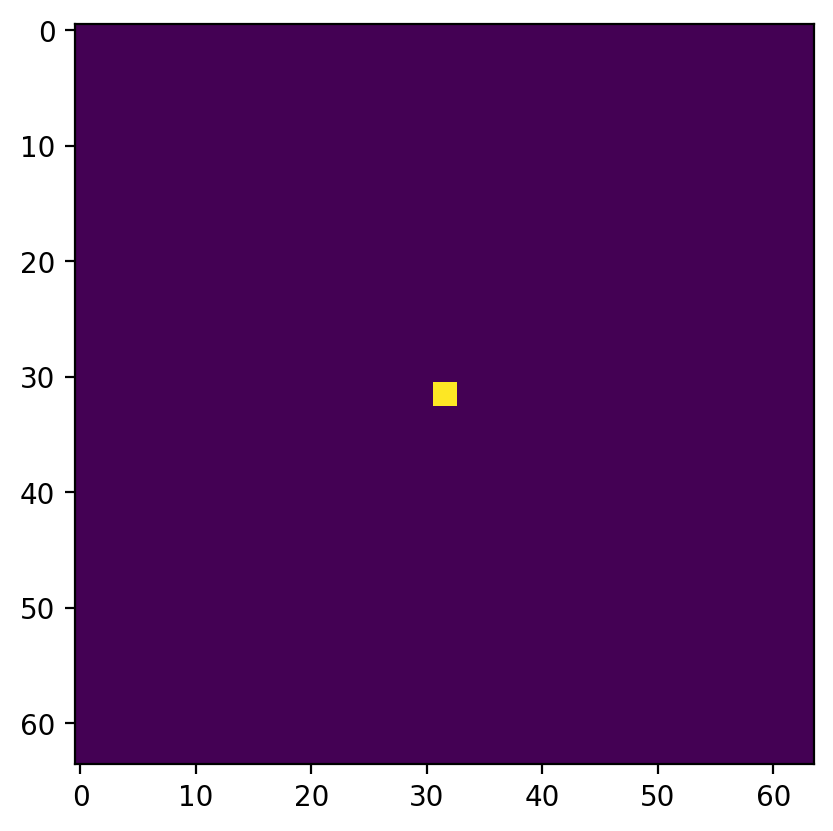

In [20]:
plt.imshow(mask)

In [21]:
from scipy.ndimage import gaussian_filter
from astropy.stats import gaussian_fwhm_to_sigma
print(gaussian_fwhm_to_sigma)
sig = gaussian_fwhm_to_sigma*psf.calculateFWHM()/.2
maskf = gaussian_filter(mask, sigma=sig)

0.42466090014400953


In [25]:
for filt in ['u','g','r','i','z','y']:
    psf = survey.get_filter(filt).psf
    sig = gaussian_fwhm_to_sigma*psf.calculateFWHM()/.2
    print(int(2*sig))

3
3
3
3
3
3


In [23]:
SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(2*sig),int(2*sig)))
maskd = cv2.morphologyEx(mask, cv2.MORPH_DILATE, SE)

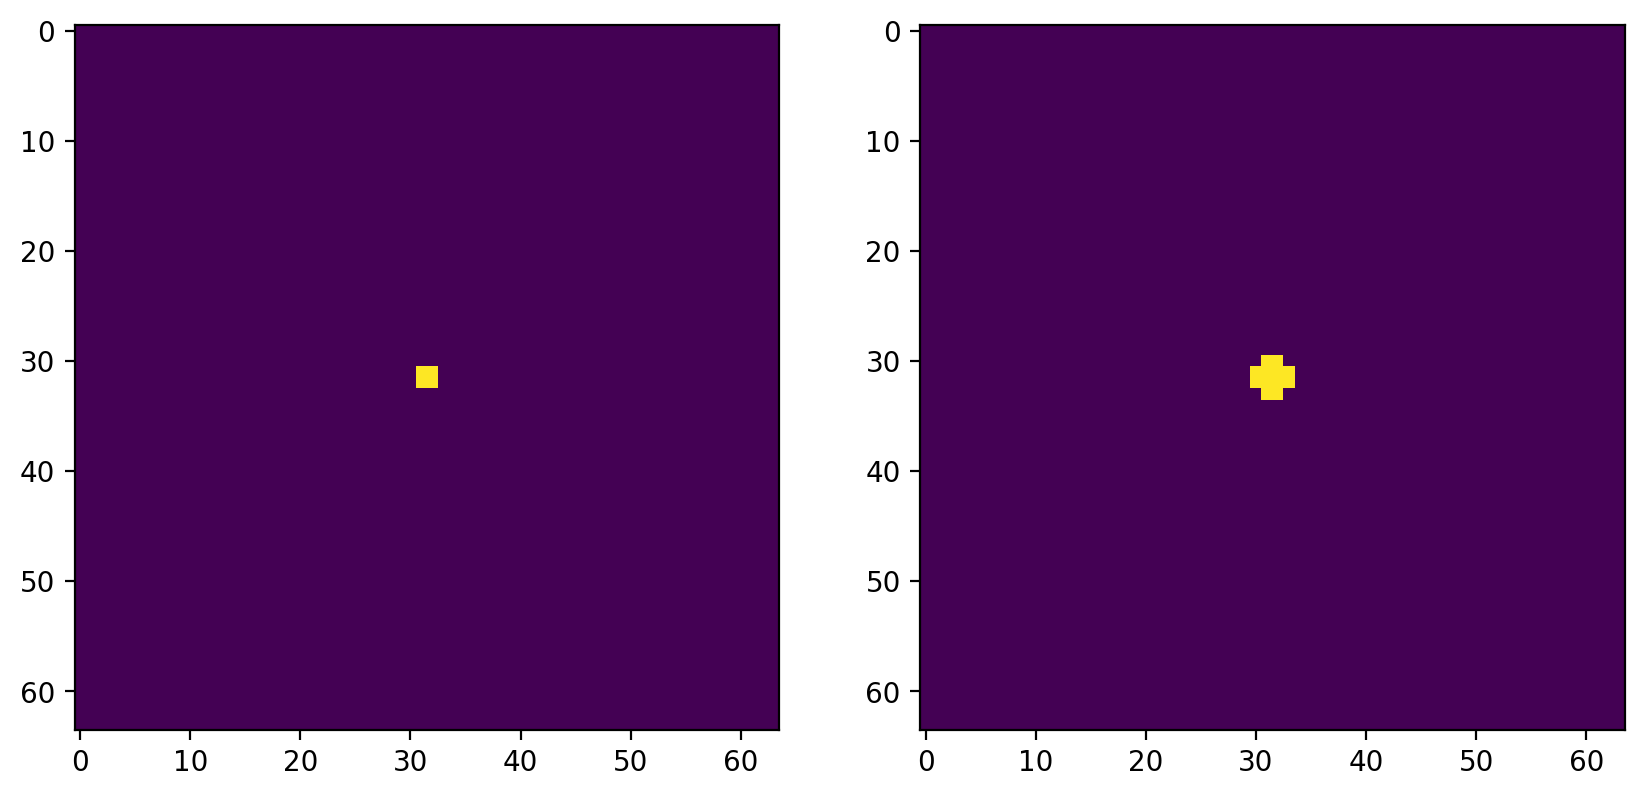

In [24]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(mask)
ax[1].imshow(maskd)

In [201]:
contours, hierarchy = cv2.findContours(
                    (mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
                )

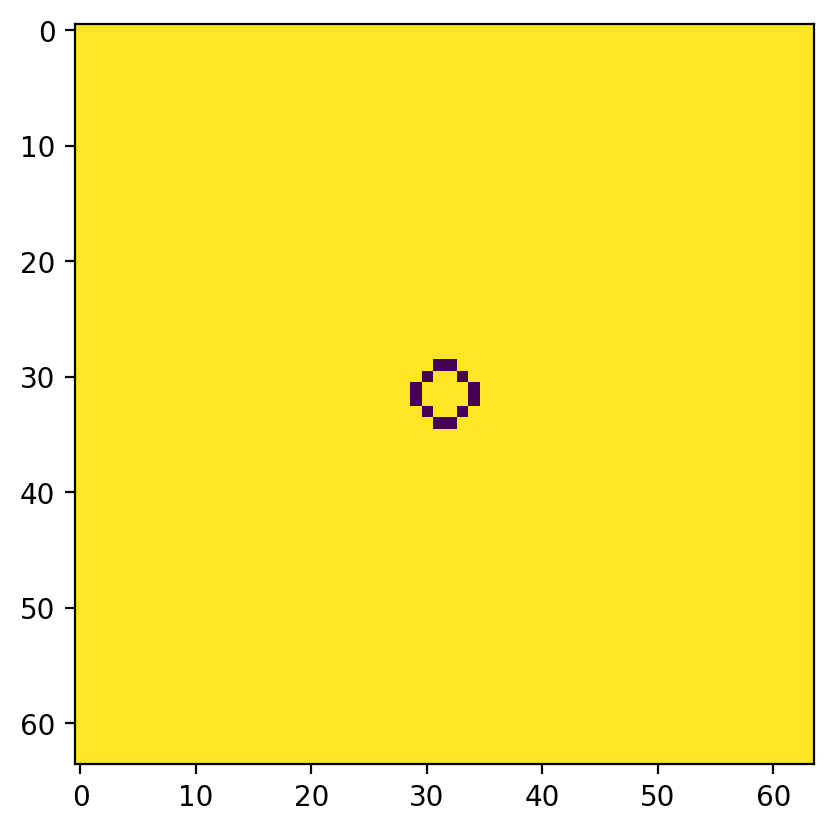

In [202]:
it = np.ones((nx,ny))
cv2.drawContours(it, contours, -1, (0,255,0), 0)
plt.imshow(it)


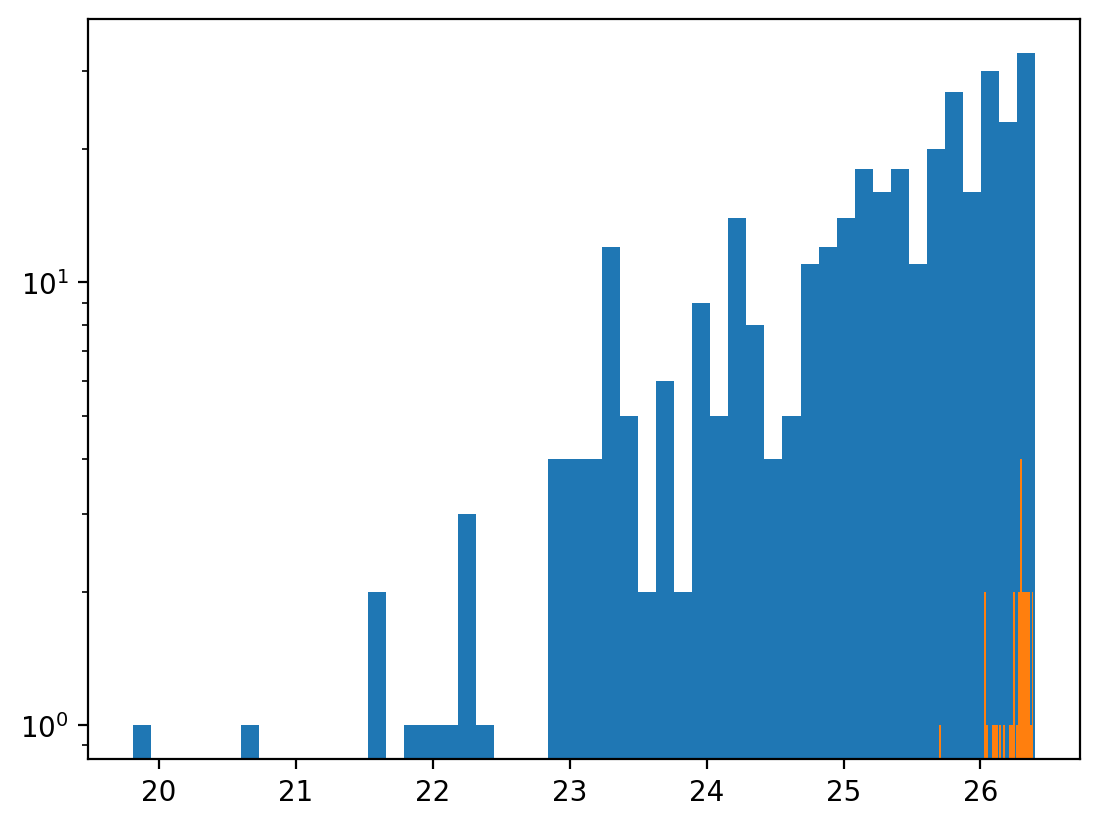

In [127]:
#plt.hist(dcutr.size_true,bins=50);
#plt.hist(dcutr.iloc[ba_inds].size_true,bins=50);


plt.hist(dcutr.mag_i,bins=50,log=True);
plt.hist(dcutr.iloc[ba_inds].mag_i,bins=50,log=True);

In [121]:
dcutr.mag_i.max()

26.397169852570507

## Visualizing Masks

In [ ]:
from detectron2.data import MetadataCatalog, DatasetCatalog


from matplotlib import colors

if "astro_test" in DatasetCatalog.list():
    print('removing astro_test')
    DatasetCatalog.remove("astro_test")
    MetadataCatalog.remove("astro_test")

red = np.array(colors.to_rgb('red'))*255
white = np.array(colors.to_rgb('white'))*255
blue = np.array(colors.to_rgb('blue'))*255
green = np.array(colors.to_rgb('green'))*255

#DatasetCatalog.register("astro_test", lambda: np.load(testfile))
astrotest_metadata = MetadataCatalog.get("astro_test").set(thing_classes=["galaxy", "star"]).set(thing_colors=[green, blue])
# astrotest_metadata_star = MetadataCatalog.get("astro_test").set(thing_classes=["star"]).set(thing_colors=[green])
#astrotest_metadata = register_data_set("astro_test", testfile, np.load, thing_classes=classes, thing_colors=green)

In [35]:
#datsm2,dcut2,psf2 = get_cutout_cat(dirpath, dpatch_btk, patchcatalog_btk, 'galaxy_id', '3828','1,2',29,nblocks=16)
#datsm2,dcut2,psf2 = get_cutout_cat(dirpath, dpatch_btk, patchcatalog_btk, 'galaxy_id', '3828','1,2',29,nblocks=16)
# datsm,dcut,psf = get_cutout_cat(dirpath, dpatch, patchcatalog, 'galaxy_id', '3828','1,2',22,nblocks=8)
datsm, dcut = get_cutout_cat(dirpath, dpatch, patchcatalog, 'galaxy_id', '3828','1,2', 0, nblocks=8)
dcutr = dcut_reformat(dcut, only_bttri=False)
survey = btk.survey.get_surveys("LSST")
dcutr['truth_type'] = 1.0
filt = 'i'
ddict, ba_inds = create_metadata(datsm,dcutr, survey,filt,lvl=5)

/tmp/ipykernel_1699522/3931048781.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_1699522/3931048781.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_y'] = ys[inds]
/tmp/ipykernel_1699522/3282477808.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

No mask 37
No mask 40
No mask 41
No mask 80
No mask 81
No mask 94
No mask 105
No mask 107
No mask 108
No mask 109
No mask 126
No mask 134
No mask 135
No mask 136
No mask 137
No mask 162
No mask 172
No mask 176
No mask 178
No mask 192
No mask 216
No mask 238
No mask 252
No mask 262
No mask 264
No mask 270
No mask 281
No mask 298
No mask 307
No mask 315
No mask 329


total instances: 156


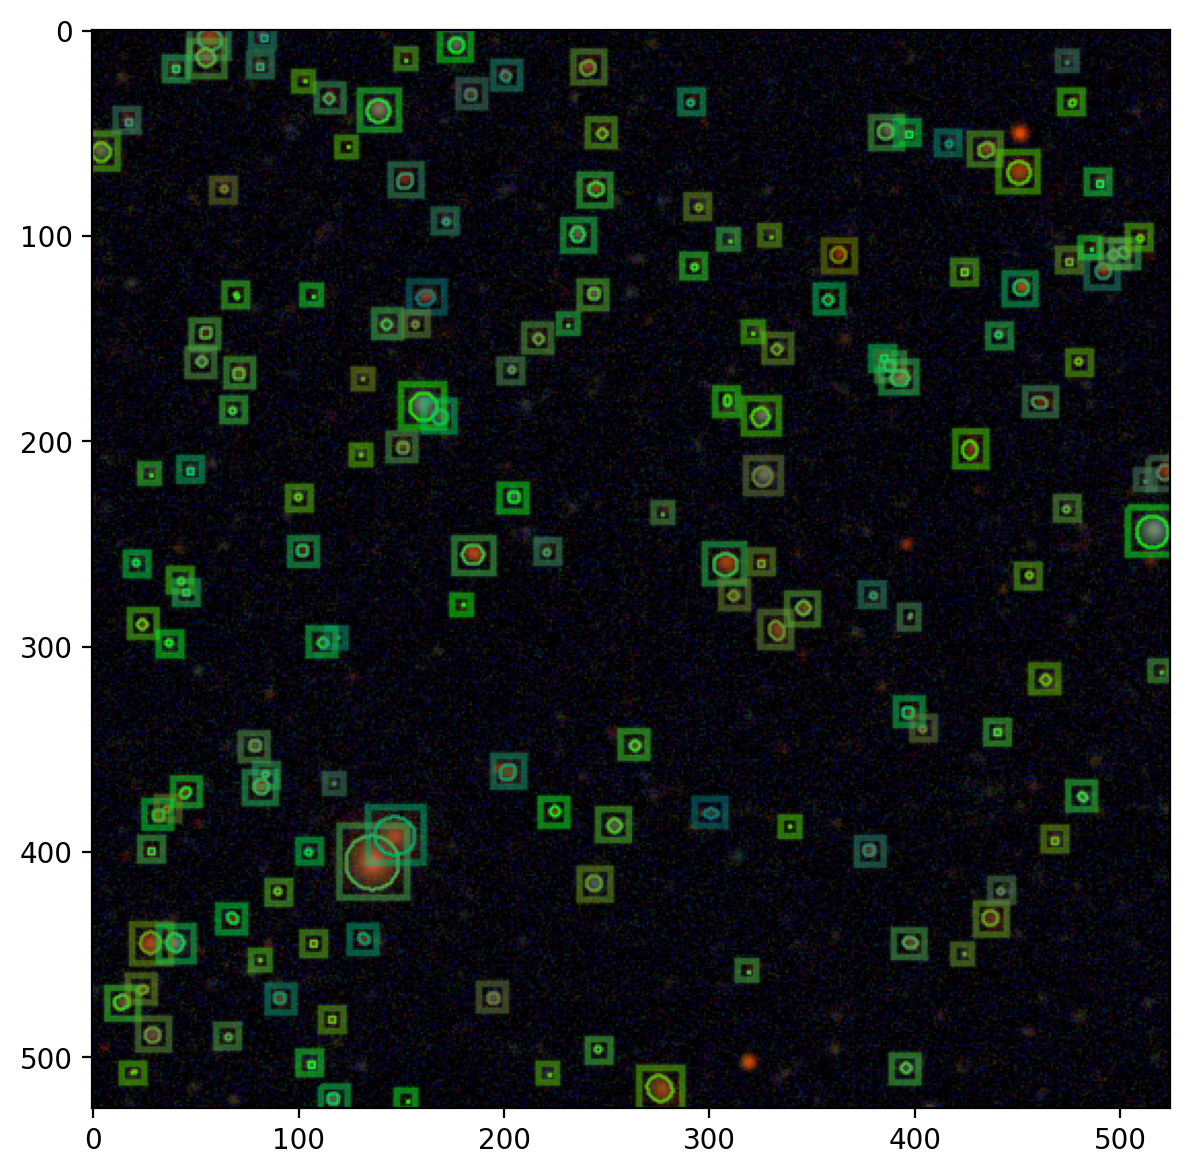

In [31]:
from deepdisc.astrodet.visualizer import ColorMode
from deepdisc.astrodet.visualizer import Visualizer
from astropy.visualization import make_lupton_rgb

plt.figure(figsize=(7,7))

image = datsm
b1 = image[2]
b2 = image[1]
b3 = image[0]
stretch=0.5
Q = 10
img = make_lupton_rgb(b1, b2, b3, minimum=0, stretch=stretch, Q=Q)

print("total instances:", len(ddict["annotations"]))
v0 = Visualizer(
    img,
    metadata=astrotest_metadata,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
)

groundTruth = v0.draw_dataset_dict(ddict, lf=False, alpha=0.1, boxf=True)

ax1 = plt.subplot(1, 1, 1)
ax1.imshow(groundTruth.get_image())
#ax1.axis("off")

#ax1.scatter(dcutr[(dcutr['new_x']>400) & (dcutr['new_y']>100)].new_x.values-400,dcutr[(dcutr['new_x']>400) & (dcutr['new_y']>100)].new_y.values-100,s=5,color='w')
#ax1.set_ylim(0,100)

total instances: 313


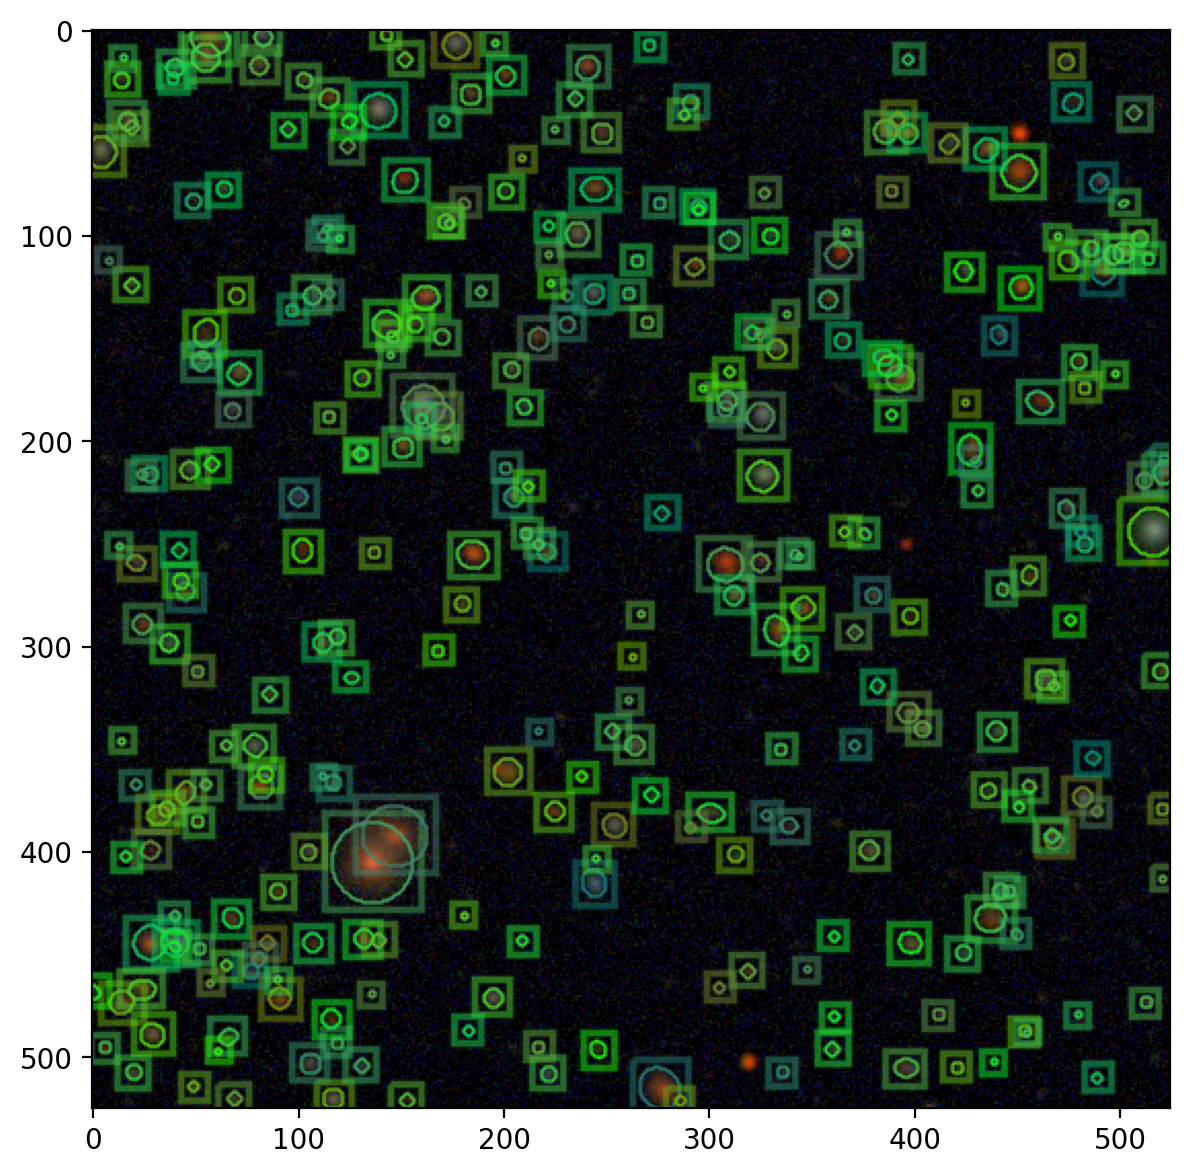

In [36]:
from deepdisc.astrodet.visualizer import ColorMode
from deepdisc.astrodet.visualizer import Visualizer
from astropy.visualization import make_lupton_rgb

plt.figure(figsize=(7,7))

image = datsm
b1 = image[2]
b2 = image[1]
b3 = image[0]
stretch=0.5
Q = 10
img = make_lupton_rgb(b1, b2, b3, minimum=0, stretch=stretch, Q=Q)

print("total instances:", len(ddict["annotations"]))
v0 = Visualizer(
    img,
    metadata=astrotest_metadata,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
)

groundTruth = v0.draw_dataset_dict(ddict, lf=False, alpha=0.1, boxf=True)

ax1 = plt.subplot(1, 1, 1)
ax1.imshow(groundTruth.get_image())
#ax1.axis("off")

#ax1.scatter(dcutr[(dcutr['new_x']>400) & (dcutr['new_y']>100)].new_x.values-400,dcutr[(dcutr['new_x']>400) & (dcutr['new_y']>100)].new_y.values-100,s=5,color='w')
#ax1.set_ylim(0,100)

In [ ]:
from deepdisc.preprocessing.get_data import get_cutout
filters = ['u','g','r','i','z','y']
#dirpath = '/home/g4merz/DC2/coadd-t3828-t3829/deepCoadd-results/'
dirpath = '/home/shared/hsc/DC2/raw_data/dr6/'
nb=16 #The number of cutouts per side of an image.  4k CCDs are too large to train with, so we reduce the size
sp=18 #The "subpatch", i.e. which of the nb x nb cutouts to use 

In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma

dall=pd.read_csv('/home/shared/hsc/DC2/raw_data/all_tracts_truth_cat.csv')
#dall=pd.read_csv('/home/g4merz/DC2/nersc_data/data/tracts_data/all_tracts_cat.csv')

ra_all = dall['ra'][:].values
dec_all = dall['dec'][:].values
allcatalog = SkyCoord(ra=ra_all*u.degree, dec=dec_all*u.degree)

dpatch=pd.read_csv('/home/shared/hsc/DC2/raw_data/3828_1,2_truthcat.csv')
#dall=pd.read_csv('/home/g4merz/DC2/nersc_data/data/tracts_data/all_tracts_cat.csv')

ra_patch = dpatch['ra'][:].values
dec_patch = dpatch['dec'][:].values
patchcatalog = SkyCoord(ra=ra_patch*u.degree, dec=dec_patch*u.degree)

In [ ]:
mag = 18.5422
flux = L0 * 10**(-0.4 * mag)

star = galsim.Gaussian(
#     fwhm=1.0e-4,
    half_light_radius=2.2925904712098424,
    flux=flux,
)


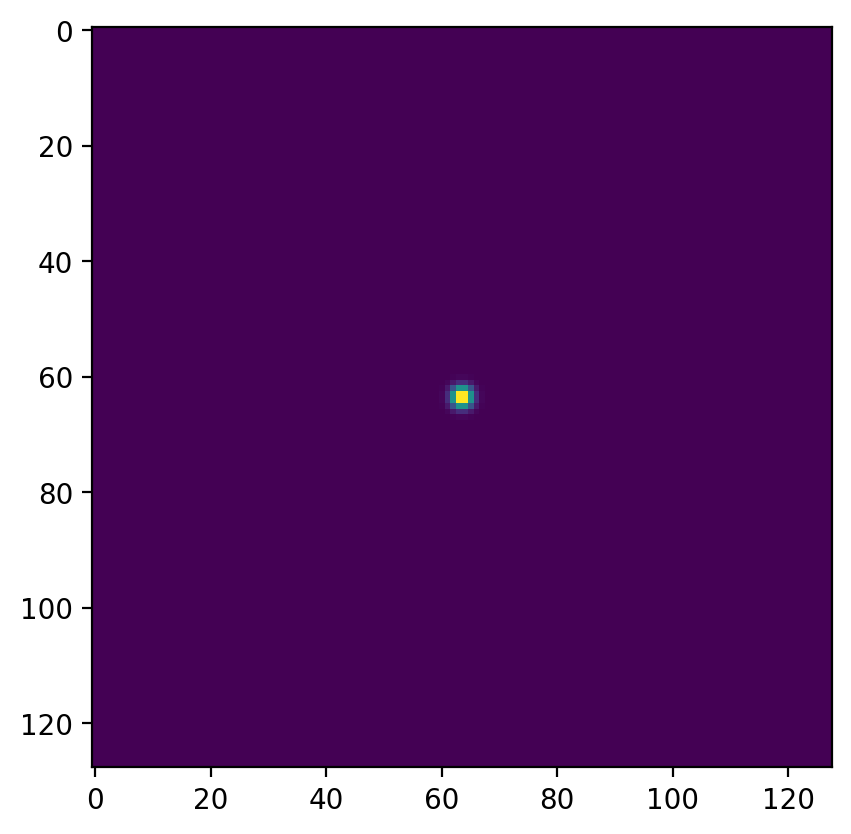

In [39]:
plt.imshow(star.drawImage(nx=128, ny=128).array)

In [41]:
df = pd.read_json('roman_data/truth/dc2_50.93_-42.0/dc2_50.93_-42.0_info_all.json', orient='records')

In [90]:
entry = df.iloc[2]
file = entry['file_name']
img = np.load(file)[0, :, :]
objs = pd.read_json(entry['objects_info'], orient='records')
# plt.axis('off')
# plt.scatter(dcut.new_x.values,dcut.new_y.values,s=1)

/tmp/ipykernel_1165372/1093784206.py:4: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  objs = pd.read_json(entry['objects_info'], orient='records')


In [97]:
ras = objs['ra'].values
decs = objs['dec'].values
cat = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)
wcs = WCS(entry['wcs'])
xs, ys = wcs.world_to_pixel(cat)

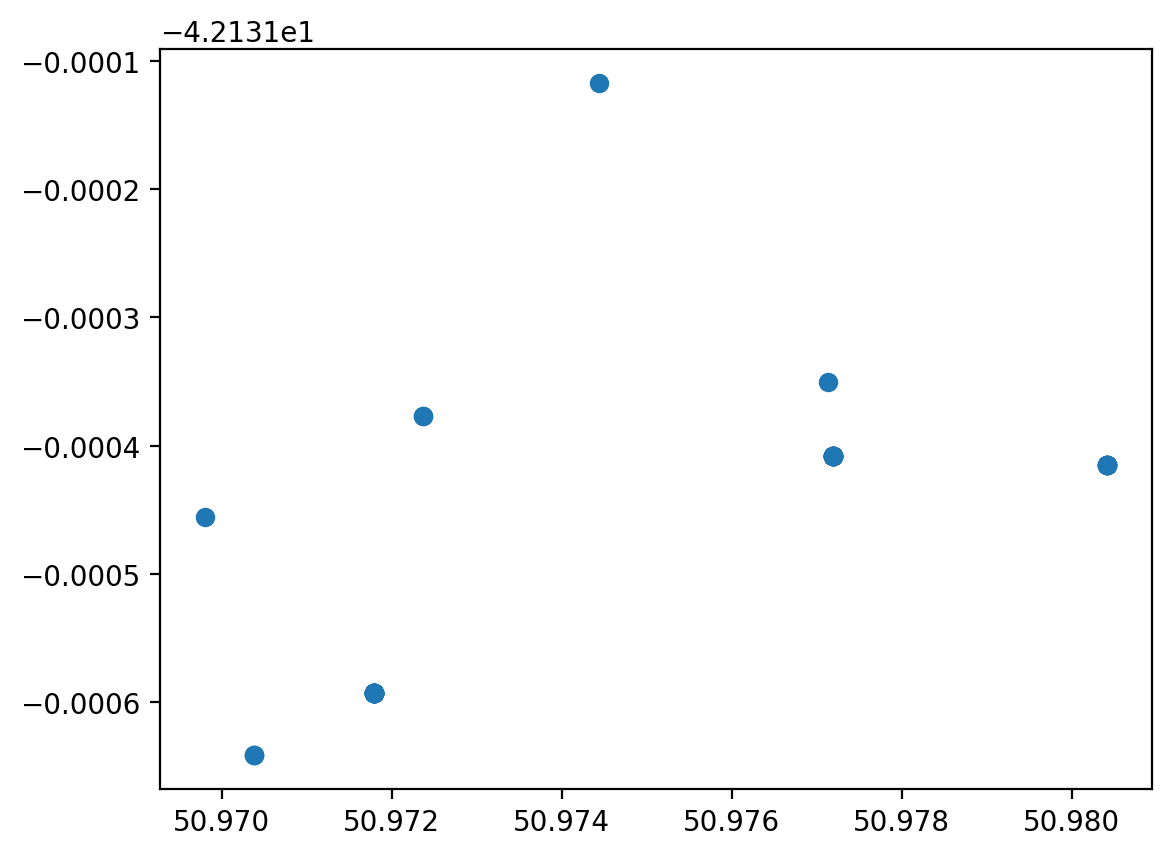

In [106]:
# plt.xlim(50.976, 51)
plt.scatter(ras,decs)

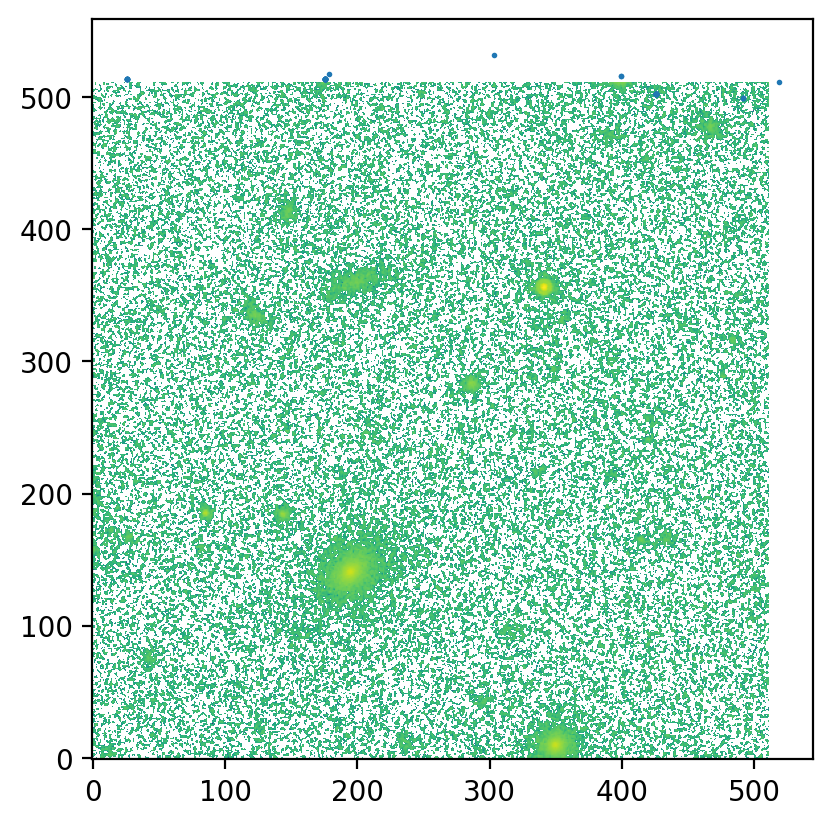

In [92]:
plt.imshow(img, norm=colors.LogNorm(), origin='lower')
# xs,ys = cutout.wcs.world_to_pixel(skycoords)
plt.scatter(xs,ys, s=1)

In [47]:
entry

image_id                                                        2
file_name       ./roman_data/truth/dc2_50.93_-42.0/full_c2_50....
wcs             WCSAXES =                    2 / Number of coo...
objects_info    [{"ind":46124835,"sca":1,"dither":133533,"x":1...
Name: 0, dtype: object